# Bayesian Outlier Modeling 
## For N-of-1 Outlier Analysis of TCGA against Normal Sets

Model outliers using a linear combination of approximations. Each background dataset, $X_i$, for each gene $j$, contributes a posterior distribution of expression $y_{i,j}$ to a linear model that learns the vector of $\beta$ weights corresponding to each background comparison distribution to model an $n$-of-1 tumor sample's distribution $z_j$. Samples drawn from the posterior distribution $z_j$ are then compared to the n-of-1 sample.

# Inputs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

import rnaseq_lib3 as r

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_hdf('/mnt/data/Objects/tcga_gtex_tpm_norm_filt.hd5')
df.head(2)

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,0.000000,10.302941,10.712460,2.750618,7.780669,...,0.000000,0.0,0.0,0.150556,0.0,0.000000,0.0,0.070387,0.790754,0.815589
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,2.970847,8.778885,10.445933,12.393268,8.440056,...,0.176318,0.0,0.0,0.411426,0.0,0.176318,0.0,0.622930,0.042644,0.378503


In [3]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Subset by dataset

In [4]:
cols = df.columns[:5].tolist()
drug_df = df[cols + drug_genes]

gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

In [5]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(gtex[gene], label='gtex')
    sns.kdeplot(normal[gene], label='normal')
    sns.kdeplot(tumor[gene], label='tumor')    
    plt.title(gene);

# Simple Model

## Learn Fits

Learn normal expression fits for all gene / dataset combinations.

In [6]:
genes = list(set(list(np.random.choice(df.columns[5:], 48, replace=False)) + ['ARAF', 'JAK2']))
len(genes)

50

In [7]:
fits = {}
for gene in genes:
    for name, dataset in [('gtex', gtex), ('normal', normal)]:
        key = f'{gene}-{name}'
        fits[key] = st.norm.fit(dataset[gene])

## Model

In [8]:
def simple_model(n_of_1, genes, datasets, fits, n_samples=200, tune=1000):
    """
    n_of_1: tumor sample 
    genes: genes to learn
    datasets: datasets to include
    fits = fits[gene-dataset] contain MAP of expression
    n_samples = Samples to learn
    """
    with pm.Model() as model:
        # Priors for linear model
        alpha = pm.Normal('alpha', 0, 5)
        beta = pm.Normal('beta', 0, 5, shape=len(datasets))
        
        # Convert fits into Normal RVs
        exp_rvs = {key: pm.Normal(key, *fits[key]) for key in fits}
        
        # Define linear model for each gene
        mu = {}
        for i, gene in enumerate(genes):
            mu[gene] = alpha
            for j, ds in enumerate(datasets):
                mu[gene] += exp_rvs[f'{gene}-{ds}'] * beta[j]
        
        # Single sigma across all genes
        sigma = pm.InverseGamma('sigma', 1)
        
        # Define z distributions for each mu
        z = {}
        for i, gene in enumerate(genes):
            obs = n_of_1[gene]
            z[gene] = pm.Laplace(gene, mu=mu[gene], b=sigma, observed=obs)
            
        return model

## Sampling Methods

Select an n_of_1 sample and train

In [9]:
tumor_id = 'TCGA-KK-A7B2-01'
n_of_1 = tumor.loc[tumor_id]

In [10]:
datasets = ['gtex', 'normal']

### Default/Auto

In [11]:
with pm.Model() as model:
    # Priors for linear model
    alpha = pm.Normal('alpha', 0, 5)
    beta = pm.Normal('beta', 0, 5, shape=len(datasets))

    # Convert fits into Normal RVs
    exp_rvs = {key: pm.Normal(key, *fits[key]) for key in fits}

    # Define linear model for each gene
    mu = {}
    for i, gene in enumerate(genes):
        mu[gene] = alpha
        for j, ds in enumerate(datasets):
            mu[gene] += exp_rvs[f'{gene}-{ds}'] * beta[j]

    # Single sigma across all genes
    sigma = pm.InverseGamma('sigma', 1)

    # Define z distributions for each mu
    z = {}
    for i, gene in enumerate(genes):
        obs = n_of_1[gene]
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=sigma, observed=obs)

In [13]:
with model:
    trace = pm.sample(200, njobs=12)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, LINC01123-normal, LINC01123-gtex, GRAMD4P3-normal, GRAMD4P3-gtex, KRTAP16-1-normal, KRTAP16-1-gtex, RP11-120M18.2-normal, RP11-120M18.2-gtex, TXNRD2-normal, TXNRD2-gtex, CROCC-normal, CROCC-gtex, CTU2-normal, CTU2-gtex, RALGAPA2-normal, RALGAPA2-gtex, RP11-102K13.5-normal, RP11-102K13.5-gtex, ARAF-normal, ARAF-gtex, TSPYL6-normal, TSPYL6-gtex, GOLGA2P9-normal

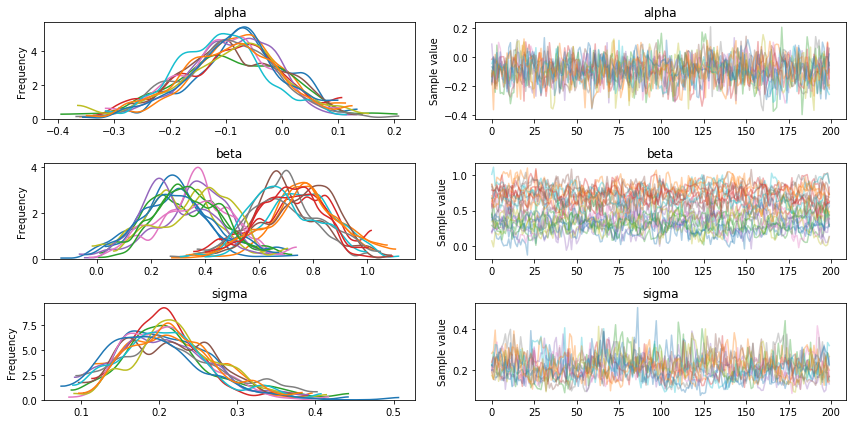

In [15]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);

### Default_with_MAP

In [16]:
with model:
    start = pm.find_MAP()
    trace = pm.sample(200, start=start, njobs=12)

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
logp = 35.458, ||grad|| = 472.84: 100%|██████████| 2205/2205 [00:14<00:00, 150.66it/s]  
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, LINC01123-normal, LINC01123-gtex, GRAMD4P3-normal, GRAMD4P3-gtex, KRTAP16-1-normal, KRTAP16-1-gtex, RP11-120M18.2-normal, RP11-120M18.2-gtex, TXNRD2-normal, TXNRD2-gtex, CROCC-normal, CROCC-gtex, CTU2-normal, CTU2-gtex, RALGAPA2-normal, RALGAPA2-gtex, RP11-102K13.5-normal, RP11-102K13.5-gtex, ARAF-normal, ARAF-gtex, TSPYL6-normal, TSPYL6-gtex, GOLGA2P9-normal, GOLGA2P9-gtex, PCAT7-normal, PCAT7-gtex, RBM6-normal, RBM6-gtex, RP1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f985bc5b908>,
      dtype=object)

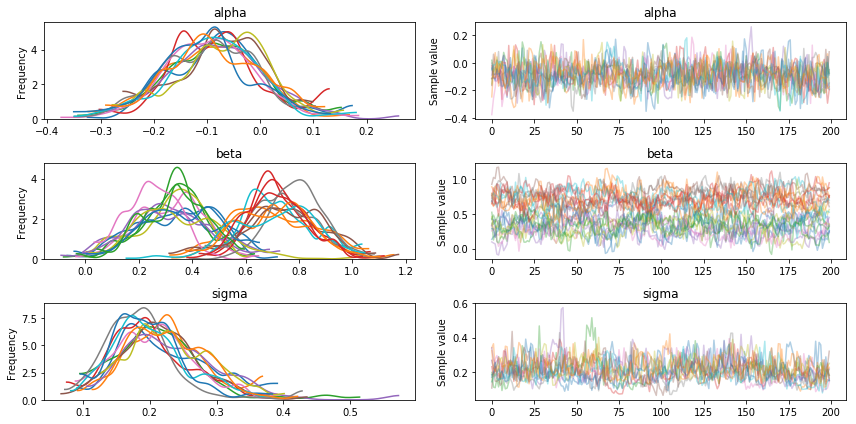

In [20]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma'])

### ADVI

In [17]:
with model:
    advi = pm.sample(200, init='advi', njobs=12)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Average Loss = 67.374:  11%|█         | 21674/200000 [01:16<10:14, 290.37it/s]
Convergence achieved at 21700
Interrupted at 21,699 [10%]: Average Loss = 433.39
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-deb

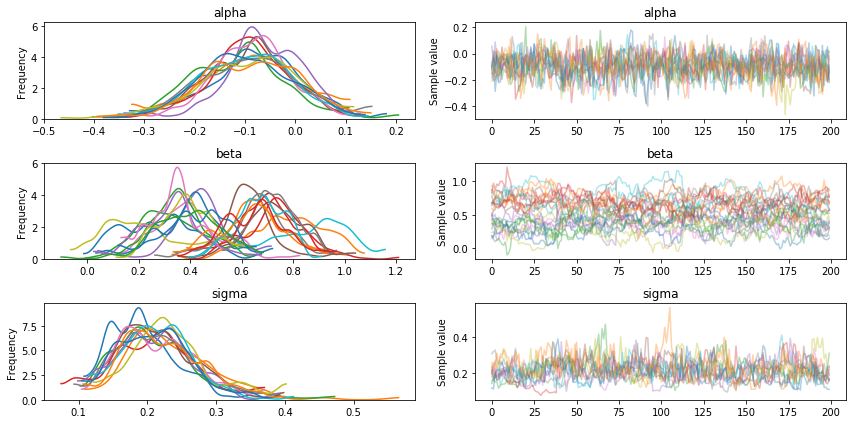

In [19]:
pm.traceplot(advi, varnames=['alpha', 'beta', 'sigma']);

### ADVI_with_MAP

In [21]:
with model:
    start = pm.find_MAP()
    advi_w_map = pm.sample(200, start=start, init='advi', njobs=12)

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
logp = 35.458, ||grad|| = 472.84: 100%|██████████| 2205/2205 [00:14<00:00, 153.13it/s]  
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 67.735:  10%|█         | 20781/200000 [01:18<11:04, 269.79it/s]
Convergence achieved at 20800
Interrupted at 20,799 [10%]: Average Loss = 459.6
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, LINC01123-normal, LINC01123-gtex, GRAMD4P3-normal, GRAMD4P3-gtex, KRTAP16-1-normal, KRTAP16-1-gtex, RP11-120M18.2-normal, RP11-120M18.2-gtex, TXNRD2-normal, TXNRD2-gtex, CROCC-normal, CROCC-gtex, CTU2-normal, CTU2-gtex, RALGAPA2-normal, RALGAPA2-gtex, RP11-102K13.5-normal, RP11-102K13

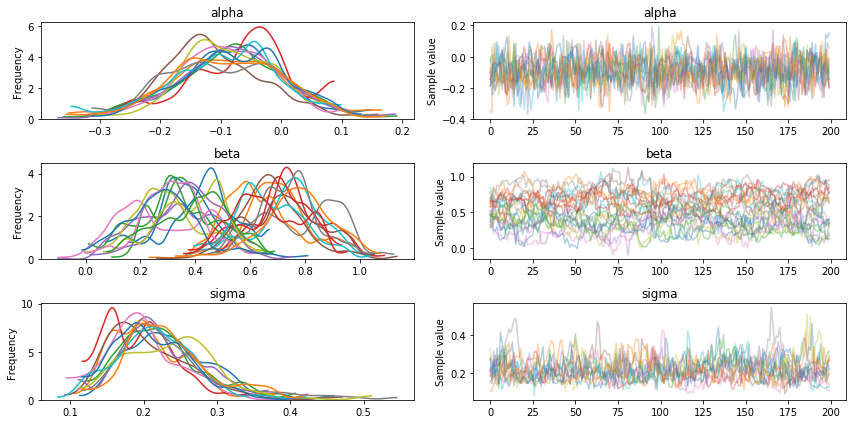

In [24]:
pm.traceplot(advi_w_map, varnames=['alpha', 'beta', 'sigma']);

### ADVI+Adapt_diag

In [25]:
with model:
    advi_adapt = pm.sample(200, init='advi+adapt_diag', njobs=12)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 67.306:  11%|█         | 22179/200000 [01:23<11:29, 257.74it/s]
Convergence achieved at 22200
Interrupted at 22,199 [11%]: Average Loss = 417.25
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, LINC01123-normal, LINC01123-gtex, GRAMD4P3-normal, GRAMD4P3-gtex, KRTAP16-1-normal, KRTAP16-1-gtex, RP11-120M18.2-normal, RP11-120M18.2-gtex, TXNRD2-normal, TXNRD2-gtex, CROCC-normal, CROCC-gtex, CTU2-normal, CTU2-gtex, RALGAPA2-normal, RALGAPA2-gtex, RP11-102K13.5-normal, RP11-102K13.5-gtex, ARAF-normal, ARAF-gtex, TSPYL6-normal, TSPYL6-gtex, GOLGA2P9-normal, GOLGA2P9-gtex, PCAT7-normal, PCAT7-gtex, RBM6-normal, RBM6-gtex, RP11-469N6.1-normal, RP11-469N6.1-gtex, AC129778.2-normal, AC129778.2-gtex, STAG1-normal, STAG1-gtex, HNRNPKP5-normal, HNRNPKP5-gtex, RP11-206L10.8-normal, RP11-206L10.8-gtex, TMED10-normal, TMED10-gtex, GNL3LP1-normal, GNL3LP1-gtex, USP19-normal, USP1

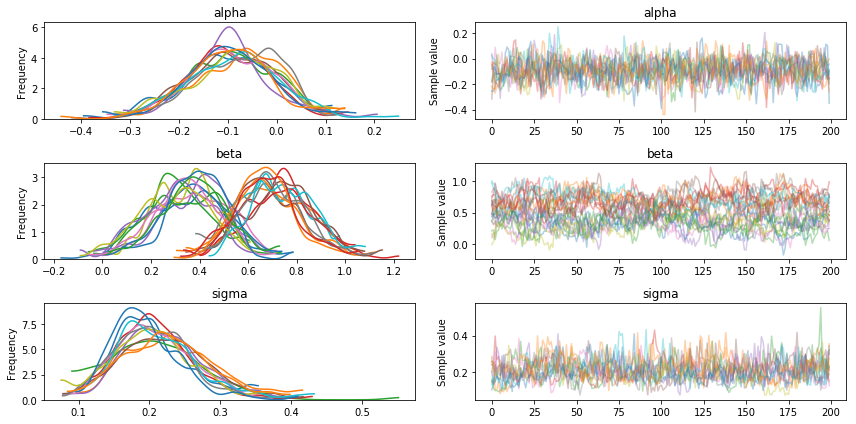

In [26]:
pm.traceplot(advi_adapt, varnames=['alpha', 'beta', 'sigma']);

### ADVI+Adapt_dig_with_MAP

In [27]:
with model:
    start = pm.find_MAP()
    advi_adapt_map = pm.sample(200, start=start, init='advi+adapt_diag', njobs=12)

logp = 35.458, ||grad|| = 472.84: 100%|██████████| 2205/2205 [00:14<00:00, 154.11it/s]  
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 67.333:  11%|█         | 21891/200000 [01:17<10:02, 295.81it/s]
Convergence achieved at 21900
Interrupted at 21,899 [10%]: Average Loss = 433.24
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, LINC01123-normal, LINC01123-gtex, GRAMD4P3-normal, GRAMD4P3-gtex, KRTAP16-1-normal, KRTAP16-1-gtex, RP11-120M18.2-normal, RP11-120M18.2-gtex, TXNRD2-normal, TXNRD2-gtex, CROCC-normal, CROCC-gtex, CTU2-normal, CTU2-gtex, RALGAPA2-normal, RALGAPA2-gtex, RP11-102K13.5-normal, RP11-102K13.5-gtex, ARAF-normal, ARAF-gtex, TSPYL6-normal, TSPYL6-gtex, GOLGA2P9-normal, GOLGA2P9-gtex, PCAT7-normal, PCAT7-gtex, RBM6-normal, RBM6-gtex, RP11-469N6.1-normal, RP11-469N6.1-gtex, AC129778.2-normal, AC129778.2-gtex, STAG1-normal, STAG1-gtex, HNRNPKP5-normal, HNRNPKP5-gtex, RP11-206L10.8-normal, RP11-20

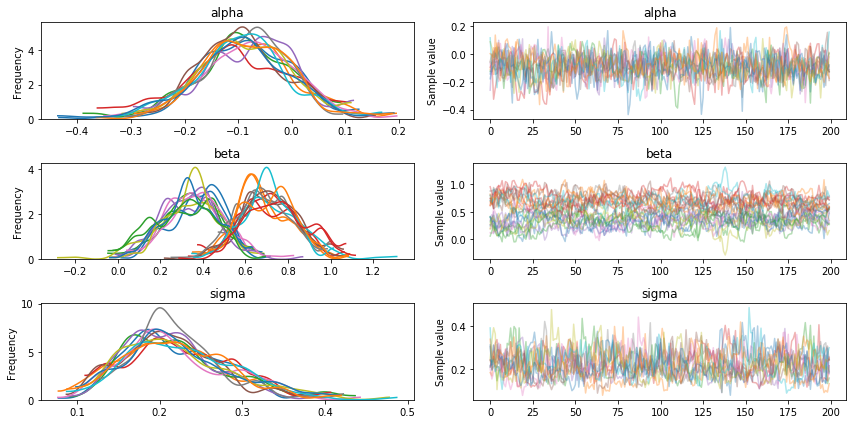

In [29]:
pm.traceplot(advi_adapt_map, varnames=['alpha', 'beta', 'sigma']);

### Metropolis

In [12]:
with model:
    step = pm.Metropolis()
    metro = pm.sample(200, step=step, njobs=12)

Only 200 samples in chain.
Multiprocess sampling (12 chains in 12 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [SCAMP1-AS1-normal]
>Metropolis: [SCAMP1-AS1-gtex]
>Metropolis: [RASGEF1A-normal]
>Metropolis: [RASGEF1A-gtex]
>Metropolis: [PPP2R5C-normal]
>Metropolis: [PPP2R5C-gtex]
>Metropolis: [MAMDC2-AS1-normal]
>Metropolis: [MAMDC2-AS1-gtex]
>Metropolis: [RPLP2-normal]
>Metropolis: [RPLP2-gtex]
>Metropolis: [RP11-867G23.4-normal]
>Metropolis: [RP11-867G23.4-gtex]
>Metropolis: [ARAF-normal]
>Metropolis: [ARAF-gtex]
>Metropolis: [SPIRE2-normal]
>Metropolis: [SPIRE2-gtex]
>Metropolis: [ERCC4-normal]
>Metropolis: [ERCC4-gtex]
>Metropolis: [XKR8-normal]
>Metropolis: [XKR8-gtex]
>Metropolis: [CTC-359D24.3-normal]
>Metropolis: [CTC-359D24.3-gtex]
>Metropolis: [OMG-normal]
>Metropolis: [OMG-gtex]
>Metropolis: [MARVELD1-normal]
>Metropolis: [MARVELD1-gtex]
>Metropolis: [CTD-3116E22.8-normal]
>Metropolis: [CTD-3116E22.8-gtex]
>Metropolis: [SDR9C7-normal]
>Metropolis: [SDR9C7-gtex]
>Metro

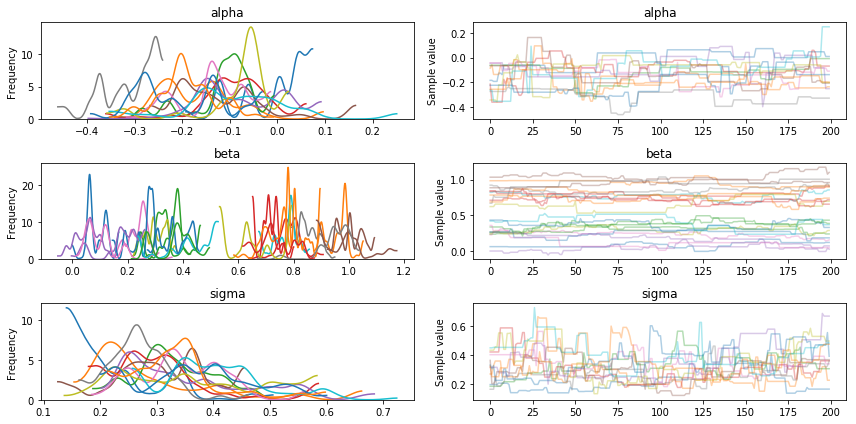

In [13]:
pm.traceplot(metro, varnames=['alpha', 'beta', 'sigma']);

### Metropolis with MAP

In [14]:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    metro_map = pm.sample(200, step=step, start=start, njobs=12)

logp = 11.881, ||grad|| = 485.73: 100%|██████████| 772/772 [00:05<00:00, 147.75it/s]   
Only 200 samples in chain.
Multiprocess sampling (12 chains in 12 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [SCAMP1-AS1-normal]
>Metropolis: [SCAMP1-AS1-gtex]
>Metropolis: [RASGEF1A-normal]
>Metropolis: [RASGEF1A-gtex]
>Metropolis: [PPP2R5C-normal]
>Metropolis: [PPP2R5C-gtex]
>Metropolis: [MAMDC2-AS1-normal]
>Metropolis: [MAMDC2-AS1-gtex]
>Metropolis: [RPLP2-normal]
>Metropolis: [RPLP2-gtex]
>Metropolis: [RP11-867G23.4-normal]
>Metropolis: [RP11-867G23.4-gtex]
>Metropolis: [ARAF-normal]
>Metropolis: [ARAF-gtex]
>Metropolis: [SPIRE2-normal]
>Metropolis: [SPIRE2-gtex]
>Metropolis: [ERCC4-normal]
>Metropolis: [ERCC4-gtex]
>Metropolis: [XKR8-normal]
>Metropolis: [XKR8-gtex]
>Metropolis: [CTC-359D24.3-normal]
>Metropolis: [CTC-359D24.3-gtex]
>Metropolis: [OMG-normal]
>Metropolis: [OMG-gtex]
>Metropolis: [MARVELD1-normal]
>Metropolis: [MARVELD1-gtex]
>Metropolis: [CTD-3116E22.8-normal]
>Metropo

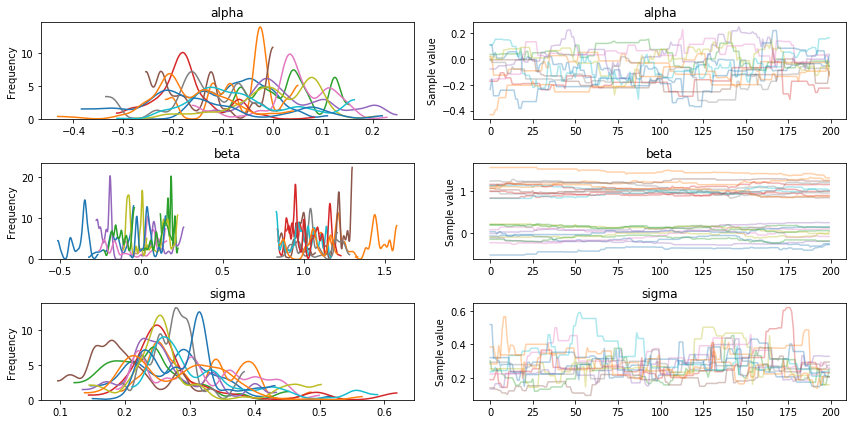

In [15]:
pm.traceplot(metro_map, varnames=['alpha', 'beta', 'sigma']);

# Center Data

In [35]:
genes = df.columns[5:]
df_c = df.copy()
df_c[genes] = df_c[genes].apply(lambda x: (x - x.mean()) / x.std())

In [36]:
gtex_c = df_c[df_c.label == 'gtex']
normal_c = df_c[df_c.label == 'tcga-normal']
tumor_c = df_c[df_c.label == 'tcga-tumor']

In [38]:
tumor_id = 'TCGA-KK-A7B2-01'
n_of_1 = tumor_c.loc[tumor_id]

In [37]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(gtex_c[gene], label='gtex')
    sns.kdeplot(normal_c[gene], label='normal')
    sns.kdeplot(tumor_c[gene], label='tumor')    
    plt.title(gene);

In [46]:
genes = list(set(list(np.random.choice(df.columns[5:], 98, replace=False)) + ['ARAF', 'JAK2']))

fits = {}
for gene in genes:
    for name, dataset in [('gtex', gtex_c), ('normal', normal_c)]:
        key = f'{gene}-{name}'
        fits[key] = st.norm.fit(dataset[gene])
len(fits)

200

In [47]:
datasets = ['gtex', 'normal']

In [48]:
with pm.Model() as model:
    # Priors for linear model
    alpha = pm.Normal('alpha', 0, 5)
    beta = pm.Normal('beta', 0, 5, shape=len(datasets))

    # Convert fits into Normal RVs
    exp_rvs = {key: pm.Normal(key, *fits[key]) for key in fits}

    # Define linear model for each gene
    mu = {}
    for i, gene in enumerate(genes):
        mu[gene] = alpha
        for j, ds in enumerate(datasets):
            mu[gene] += exp_rvs[f'{gene}-{ds}'] * beta[j]

    # Single sigma across all genes
    sigma = pm.InverseGamma('sigma', 1)

    # Define z distributions for each mu
    z = {}
    for i, gene in enumerate(genes):
        obs = n_of_1[gene]
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=sigma, observed=obs)

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock


In [49]:
with model:
    trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86

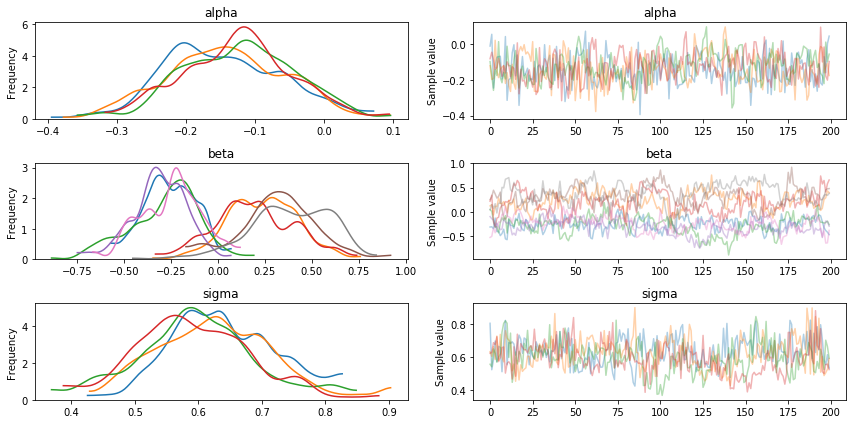

In [50]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);